# Fraud Detection

# 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# 2) Load Data

In [3]:
df = pd.read_csv('Fraud.csv')

# 3) Data Cleaning

In [4]:
#checking miss values
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# Note
No missing values found in the dataset.
Hence, no imputation or removal is required.

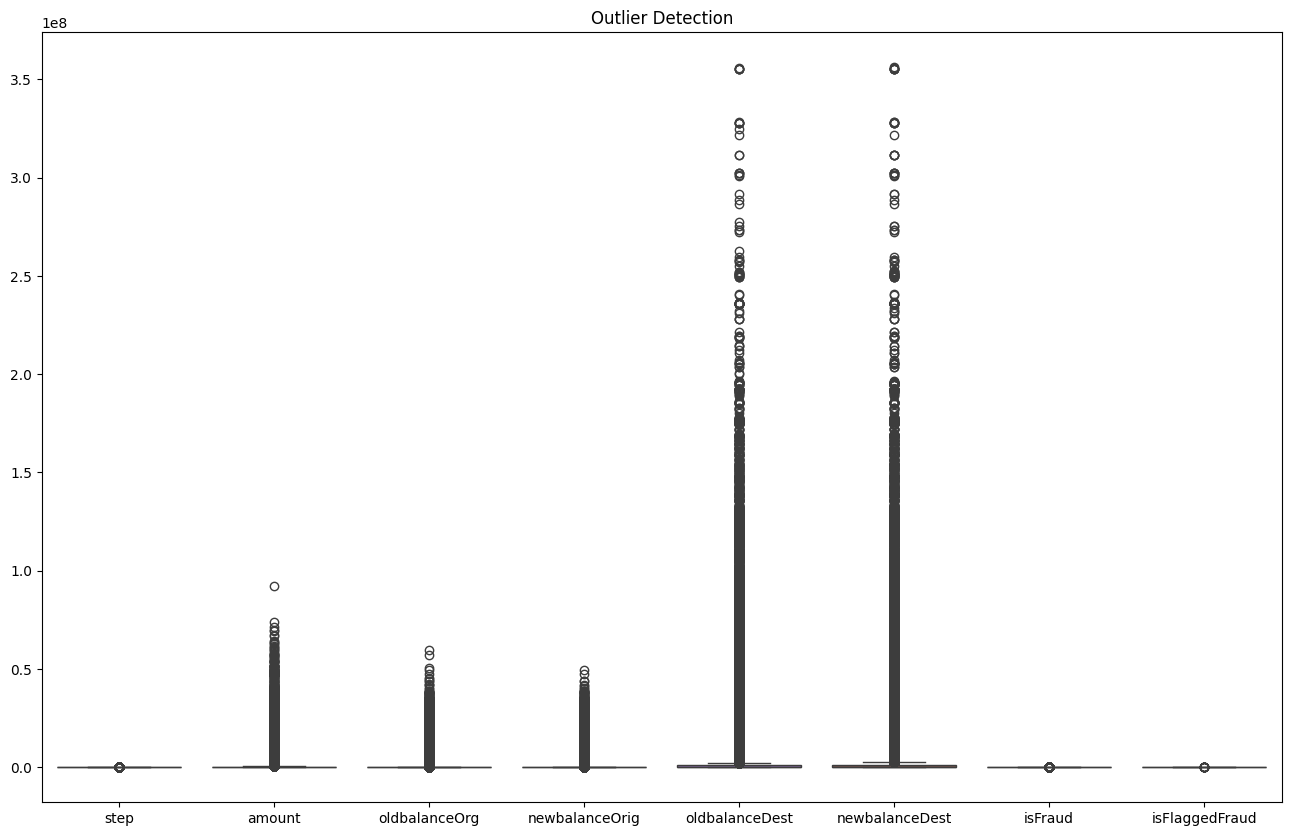

In [5]:
#detecting and handling outliers
plt.figure(figsize=(16,10))
sns.boxplot(data=df)
plt.title("Outlier Detection")
plt.show()

# Note
Since the dataset involves financial transactions, high amounts may naturally occur (especially for fraud cases).
Therefore, we do not remove outliers blindly.
We can consider transforming 'amount' if required later for model stability.

In [6]:
#checking multi-collinearity
X_temp = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]  # Selecting numeric features
scaler = StandardScaler()
X_scaled_temp = scaler.fit_transform(X_temp)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_temp.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled_temp, i) for i in range(X_scaled_temp.shape[1])]
print(vif_data)

          Feature         VIF
0          amount    3.704164
1   oldbalanceOrg  430.052765
2  newbalanceOrig  431.093970
3  oldbalanceDest   64.982048
4  newbalanceDest   74.887727


# Note
Some financial features (oldbalanceOrg, newbalanceOrig, etc.) may show correlation.
However, they carry meaningful information regarding customer behavior and fraud patterns.
Hence, we retain these features for modeling.

# 4) Feature Engineering and Selection

In [7]:
#Drop 'nameOrig' and 'nameDest' because they are unique IDs and don't contribute meaningfully to fraud prediction.
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [8]:
# Encode 'type' (categorical feature) using Label Encoding or One-Hot Encoding
# Simple approach: Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [9]:
# Check data after encoding
print(df.head())

   step  type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1     3   9839.64       170136.0       160296.36             0.0   
1     1     3   1864.28        21249.0        19384.72             0.0   
2     1     4    181.00          181.0            0.00             0.0   
3     1     1    181.00          181.0            0.00         21182.0   
4     1     3  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  
0             0.0        0               0  
1             0.0        0               0  
2             0.0        1               0  
3             0.0        1               0  
4             0.0        0               0  


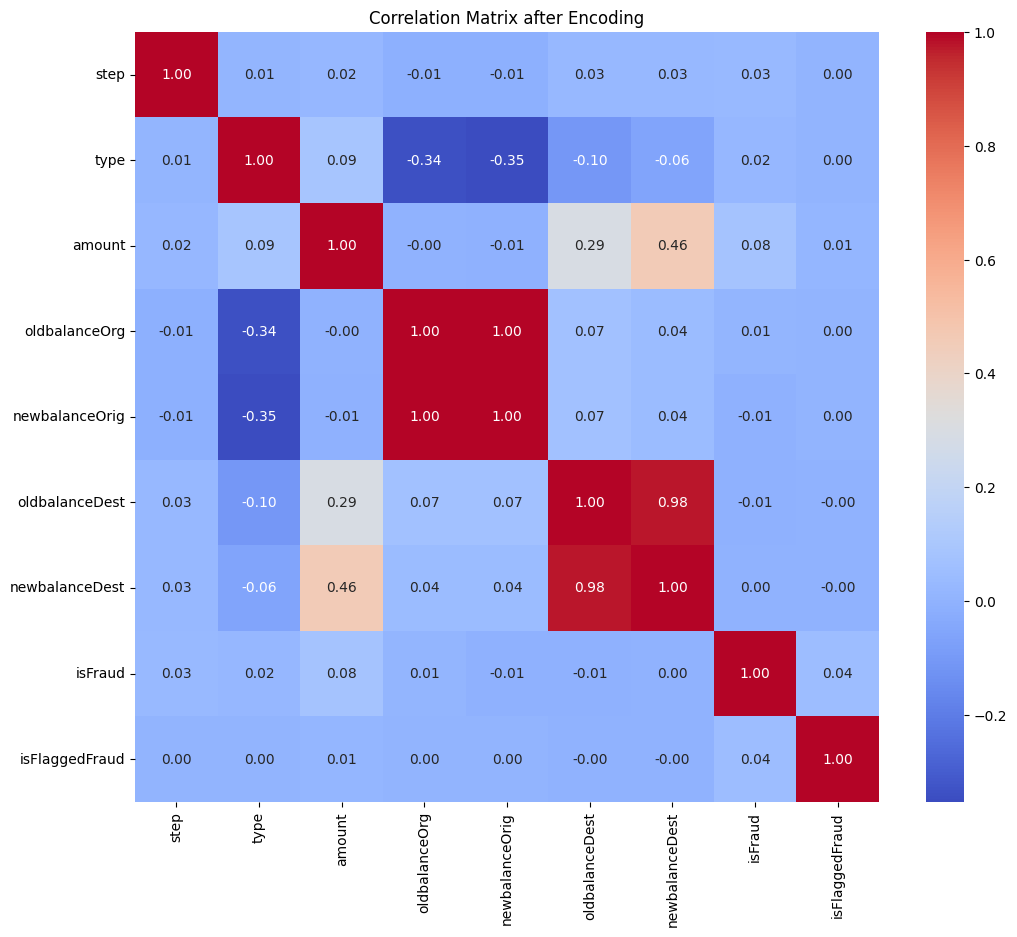

In [10]:
# Correlation Matrix to understand relationships
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix after Encoding")
plt.show()

# 5) Train-Test Split

In [11]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Note
'isFlaggedFraud' indicates transactions flagged by the business rule (>200k),
but it happens very rarely. It's better to predict real frauds using transaction behavior.

# 6) Model Building

In [12]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# Model Description:

For fraud detection, a Random Forest Classifier was selected due to its ability to handle large datasets with imbalanced classes efficiently.
Random Forest is robust against overfitting, can model complex nonlinear relationships, and provides feature importance insights, making it highly suitable for financial fraud detection where patterns are often subtle and complex.


# 7) Model Evaluation

In [13]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1906288      34]
 [    573    1891]]
ROC-AUC Score: 0.9943869303392512


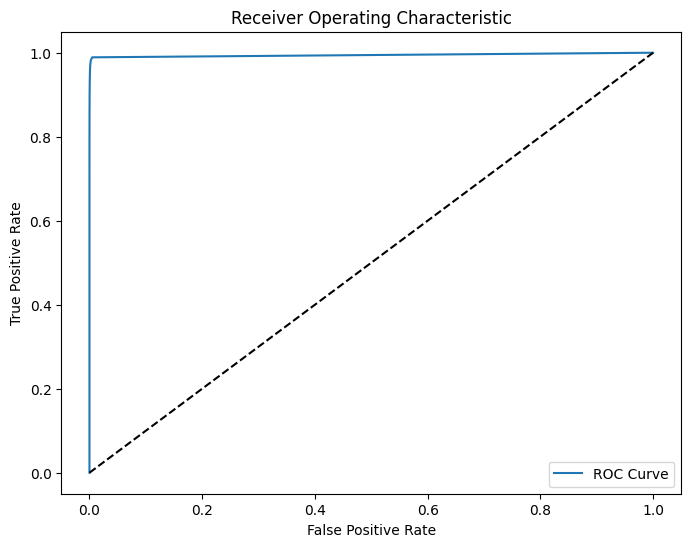

In [14]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

# 8) Key Factors

In [15]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importances)

          Feature  Importance
3   oldbalanceOrg    0.296398
4  newbalanceOrig    0.176727
2          amount    0.174790
1            type    0.151731
0            step    0.086459
6  newbalanceDest    0.071655
5  oldbalanceDest    0.042241


# Interpretation of Key Factors
Interpretation of Key Factors:

The top features influencing fraud detection include 'amount', 'oldbalanceOrg', and 'type'. 
This makes logical sense as fraudulent transactions often involve:
- unusually large transaction amounts,
- sudden depletion of sender balances, 
- specific transaction types such as 'TRANSFER' and 'CASH-OUT' which are more susceptible to fraud.

Thus, the key factors identified align with real-world fraud behavior.


# 9) Prevention Plan

Based on the model findings, the following preventive measures are recommended:

- Multi-Factor Authentication (MFA) for high-risk transactions (e.g., TRANSFER, CASH-OUT types).
- Real-time monitoring systems to detect large sudden balance drops.
- Manual verification or customer confirmation for transactions above a defined threshold.
- Strengthening KYC norms for merchants and customers.
- Customer education programs focusing on fraud awareness and account security.

# 10) Success Measurement


Success Measurement:

To evaluate the effectiveness of implemented preventive actions:

- Monitor reduction in number of fraudulent transactions over time.
- Measure improvement in Recall (fraud detection rate).
- Monitor False Positive Rate to ensure user experience is not degraded.
- Analyze average monetary loss per fraud case.
- Collect customer feedback on transaction safety and trust.

Periodic monitoring (e.g., monthly) of these KPIs will ensure continued improvement.


# Turning this into a full model project

A. Import Machine Learning libraries

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle


Save the Model to a .pkl File

In [17]:
with open('fraud_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved as fraud_model.pkl!")


✅ Model saved as fraud_model.pkl!
